# 1. Load libraries and create some functions

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                 

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on F1-score optimization.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [5]:
def build_model(base_model, transfer_learning):
    """
    Constructs and returns a neural network model tailored for binary classification of grayscale images. 

    This function adapts a given base model for grayscale input by adding a custom input layer and a Conv2D 
    layer to convert the single-channel input into a three-channel format compatible with the base model. 
    The base model can be set as trainable or non-trainable based on the 'transfer_learning' parameter. 
    When transfer learning is enabled ('Y'), all layers of the base model are frozen; otherwise, they are 
    left trainable ('N'). 

    The network is extended with three additional custom dense layers for feature processing and classification. 
    The final output layer uses a sigmoid activation function, making the model suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-trained model to be used as the starting point.
    - transfer_learning (str): A flag indicating whether to enable ('Y') or disable ('N') transfer learning by freezing the base model.

    Returns:
    - keras.Model: The constructed binary classification model.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the MobileNet model
    x = base_model(x)

    # Add own top layers for classification
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [6]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# 2. Load data

In [7]:
pla_train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

pla_val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

pla_test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 748 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


# 3. Class Weights

In [8]:
labels = []
for _, label in pla_train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
pla_class_weights_dict = dict(zip(class_labels, class_weights))
pla_class_weights_dict = {int(key): value for key, value in pla_class_weights_dict.items()}
pla_class_weights_dict

{0: 0.06016042780748665, 1: 0.9398395721925134}

# 4. VGG16 TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on VGG16 architecture. All layers are frozen except for the last 4 layers (new weights will be calculated based on the ultrasound images), and 4 additional custom layers are added. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from Imagenet, then 4 layers with weights fine tuned by the brain classifier, and then 4 layers to fine tune the placenta images.

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# 4B. VGG16 NO Transfer Learning

## 4B.1. Train Brains Classifier

## 4B.2. Train Placenta Classifier (fine-tuning from previous model)

In [25]:
## Placenta classifier
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Load saved brain model
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

base_model.trainable set to False


In [26]:
# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:  
    layer.trainable = True

# check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)

model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # lower learning rate
                    loss='binary_crossentropy',
                    metrics=METRICS)

<keras.src.engine.input_layer.InputLayer object at 0x7fee5c41a950> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7feecc4826e0> True
<keras.src.engine.functional.Functional object at 0x7fee5c418940> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7fee4c668640> True
<keras.src.layers.core.dense.Dense object at 0x7feef1386b30> True
<keras.src.layers.core.dense.Dense object at 0x7fee4c6fac20> True
<keras.src.layers.core.dense.Dense object at 0x7fee4c6fbe50> True


In [27]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion
pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

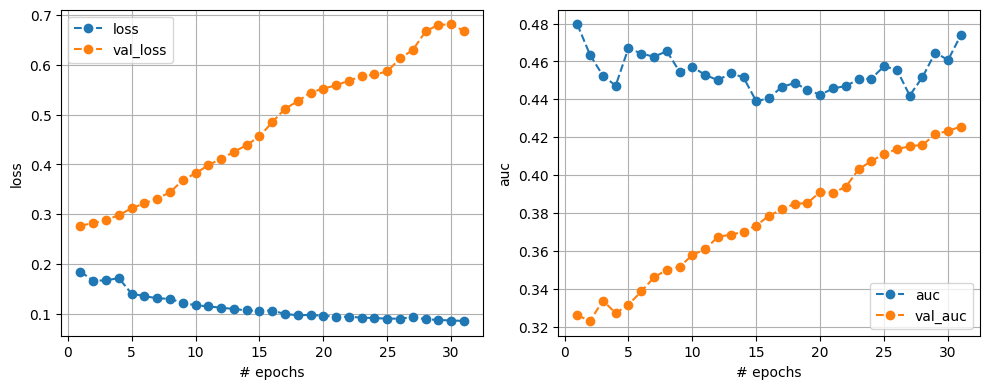

24/24 [==============================] - 7s 230ms/step - loss: 0.0861 - auc: 0.4739 - val_loss: 0.6678 - val_auc: 0.4256
Training time: 221.68279504776 seconds


In [28]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                      epochs=150,
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.55 with F1-score: 0.30


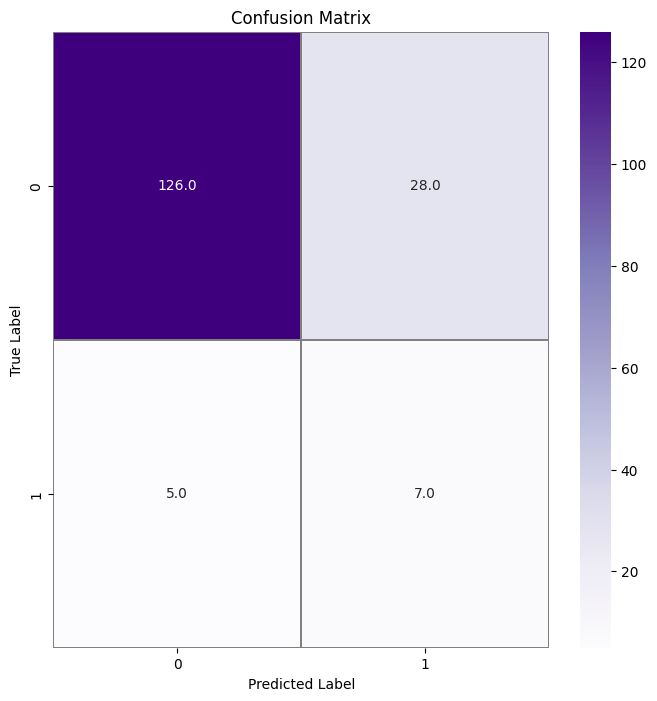

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       154
           1       0.20      0.58      0.30        12

    accuracy                           0.80       166
   macro avg       0.58      0.70      0.59       166
weighted avg       0.91      0.80      0.84       166

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL  0.78                      0.3       0.8         0.58   

   Specificity  PPV   NPV   PLR   NLR  
0         0.82  0.2  0.96  3.21  0.51  


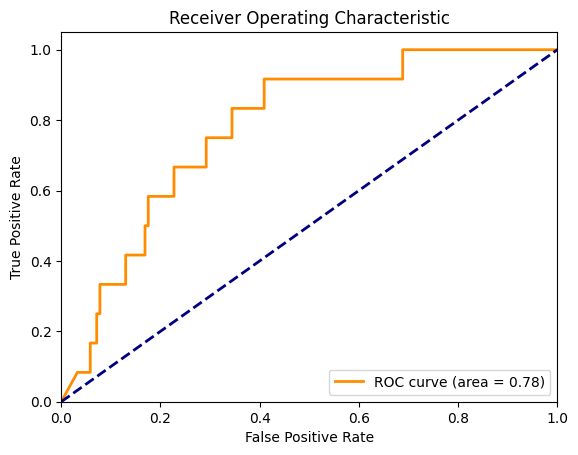

In [29]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL')

# Train on anterior placenta planes only

In [39]:
pla_train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

pla_val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

pla_test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 384 files belonging to 2 classes.
Found 78 files belonging to 2 classes.
Found 87 files belonging to 2 classes.


In [42]:
labels = []
for _, label in pla_train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
pla_class_weights_dict = dict(zip(class_labels, class_weights))
pla_class_weights_dict = {int(key): value for key, value in pla_class_weights_dict.items()}
pla_class_weights_dict

{0: 0.0546875, 1: 0.9453125}

In [43]:
## Placenta classifier
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Load saved brain model
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

base_model.trainable set to False


In [44]:
# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:  
    layer.trainable = True

# check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)

model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # lower learning rate
                    loss='binary_crossentropy',
                    metrics=METRICS)

<keras.src.engine.input_layer.InputLayer object at 0x7c6858196500> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c683214d210> True
<keras.src.engine.functional.Functional object at 0x7c683214cc70> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7c684dbf9db0> True
<keras.src.layers.core.dense.Dense object at 0x7c683239e380> True
<keras.src.layers.core.dense.Dense object at 0x7c68445df610> True
<keras.src.layers.core.dense.Dense object at 0x7c683239f490> True


In [45]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion to your datasets
pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

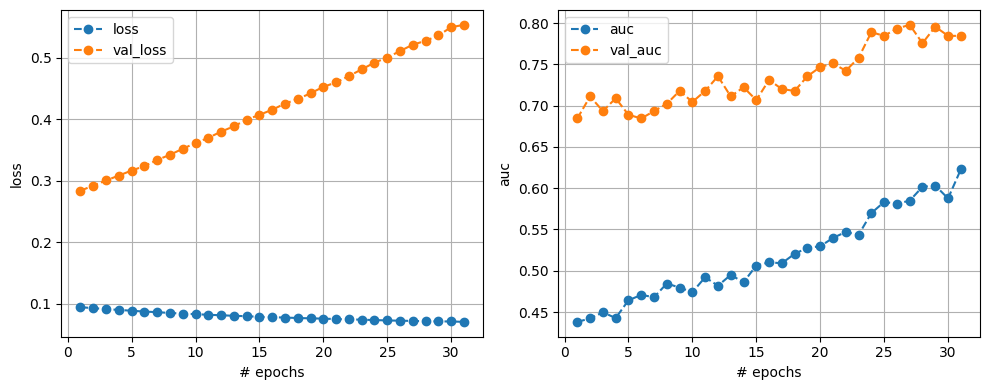

12/12 [==============================] - 6s 392ms/step - loss: 0.0707 - auc: 0.6227 - val_loss: 0.5531 - val_auc: 0.7844
Training time: 211.1831033229828 seconds


In [46]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                      epochs=150,
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.40 with F1-score: 0.16


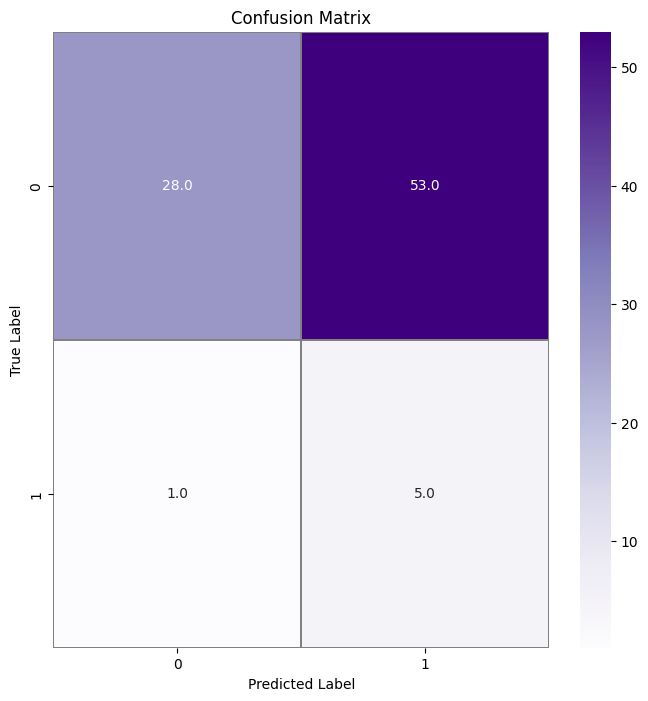

              precision    recall  f1-score   support

           0       0.97      0.35      0.51        81
           1       0.09      0.83      0.16         6

    accuracy                           0.38        87
   macro avg       0.53      0.59      0.33        87
weighted avg       0.90      0.38      0.48        87

             Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL-anterior  0.44                     0.16      0.38         0.83   

   Specificity   PPV   NPV   PLR   NLR  
0         0.35  0.09  0.97  1.27  0.48  


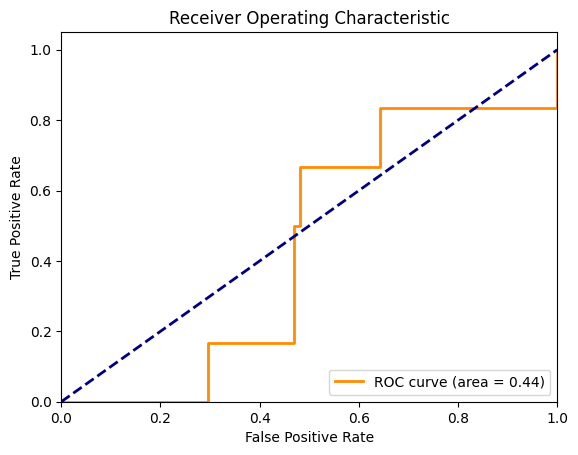

In [47]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-anterior')

# Train on posterior placenta planes only

In [48]:
pla_train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

pla_val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

pla_test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 363 files belonging to 2 classes.
Found 76 files belonging to 2 classes.
Found 85 files belonging to 2 classes.


In [49]:
labels = []
for _, label in pla_train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
pla_class_weights_dict = dict(zip(class_labels, class_weights))
pla_class_weights_dict = {int(key): value for key, value in pla_class_weights_dict.items()}
pla_class_weights_dict

{0: 0.06611570247933884, 1: 0.9338842975206612}

In [50]:
## Placenta classifier
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Load saved brain model
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

base_model.trainable set to False


In [51]:
# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:  
    layer.trainable = True

# check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)

model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # lower learning rate
                    loss='binary_crossentropy',
                    metrics=METRICS)

<keras.src.engine.input_layer.InputLayer object at 0x7c684c4f8cd0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c684d868250> True
<keras.src.engine.functional.Functional object at 0x7c684c4fa9e0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7c68744925f0> True
<keras.src.layers.core.dense.Dense object at 0x7c684d86bb80> True
<keras.src.layers.core.dense.Dense object at 0x7c6832447af0> True
<keras.src.layers.core.dense.Dense object at 0x7c6832444ca0> True


In [52]:
# preprocesar input
pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

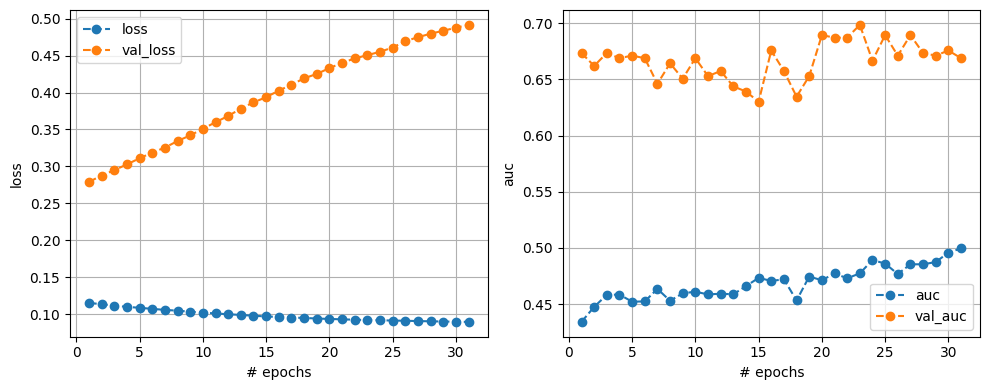

12/12 [==============================] - 5s 379ms/step - loss: 0.0895 - auc: 0.4996 - val_loss: 0.4917 - val_auc: 0.6689
Training time: 196.31818413734436 seconds


In [53]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                      epochs=150,
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.38 with F1-score: 0.25


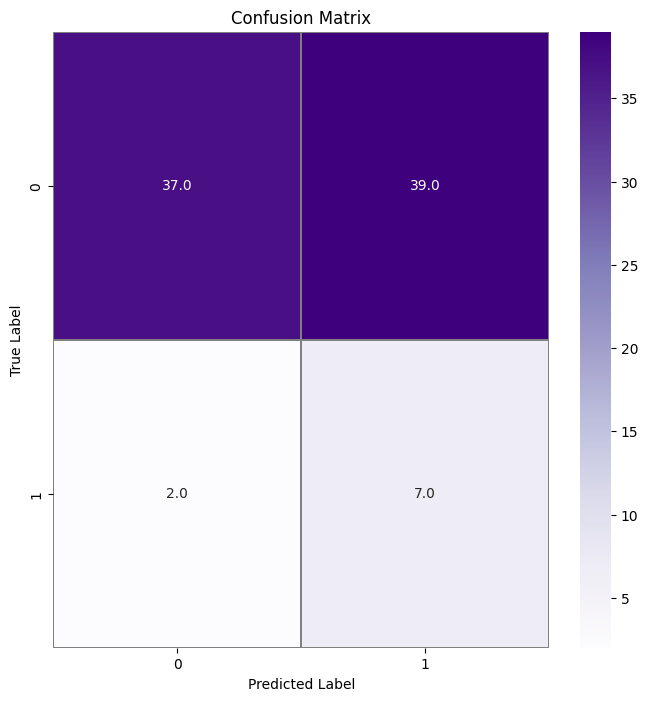

              precision    recall  f1-score   support

           0       0.95      0.49      0.64        76
           1       0.15      0.78      0.25         9

    accuracy                           0.52        85
   macro avg       0.55      0.63      0.45        85
weighted avg       0.86      0.52      0.60        85

              Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  VGG16-no-TL-posterior  0.58                     0.25      0.52   

   Sensitivity  Specificity   PPV   NPV   PLR   NLR  
0         0.78         0.49  0.15  0.95  1.52  0.46  


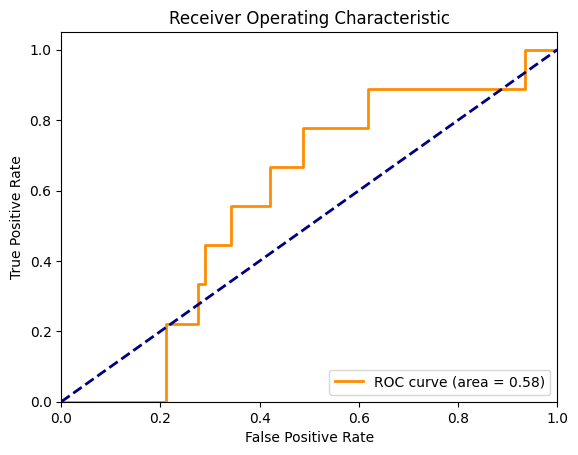

In [54]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-posterior')

# Hypertune parameters of best model

Best model after re-training on different planes: anterior and posterior planes combined

In [10]:
pla_train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

pla_val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

pla_test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/pre-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 748 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


In [11]:
labels = []
for _, label in pla_train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
pla_class_weights_dict = dict(zip(class_labels, class_weights))
pla_class_weights_dict = {int(key): value for key, value in pla_class_weights_dict.items()}
pla_class_weights_dict

{0: 0.06016042780748665, 1: 0.9398395721925134}

In [12]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion to your datasets
pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

In [16]:
import optuna

def build_model(base_model, transfer_learning, trial):
    # Base model is kept as is, especially if it has pre-trained weights
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True

    # Define input and add Conv2D layer to expand grayscale to three channels
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = base_model(x)

    # Flatten and add Dense layers
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)  # Keep the number of units fixed as in original model
    x = Dense(20, activation='relu')(x)  # Keep the number of units fixed as in original model
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    # Optuna: Optimize the learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=METRICS)  # Replace 'accuracy' with your metrics

    return model


In [17]:
def objective(trial):
    ## Placenta classifier
    base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Load saved brain model
    model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y', trial=trial)
    model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')
    
    # Unfreeze four top layers
    for layer in model_VGG16.layers[-4:]:  
        layer.trainable = True
    
    # Entrenamiento de la red
    start = time.time()

    pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
    pla_vgg_tl_plot_callback = PlotLearning()

    history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                          epochs=150,
                                          validation_data=pla_prep_val_data,
                                          callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                          class_weight=pla_class_weights_dict
                                         )  

    end = time.time()

    print('Training time:', end - start, 'seconds')

    # Evaluate the model on the validation set
    _, auc = model_VGG16.evaluate(pla_prep_val_data, verbose=0)
    
    # Return the accuracy as the value to be optimized
    return auc

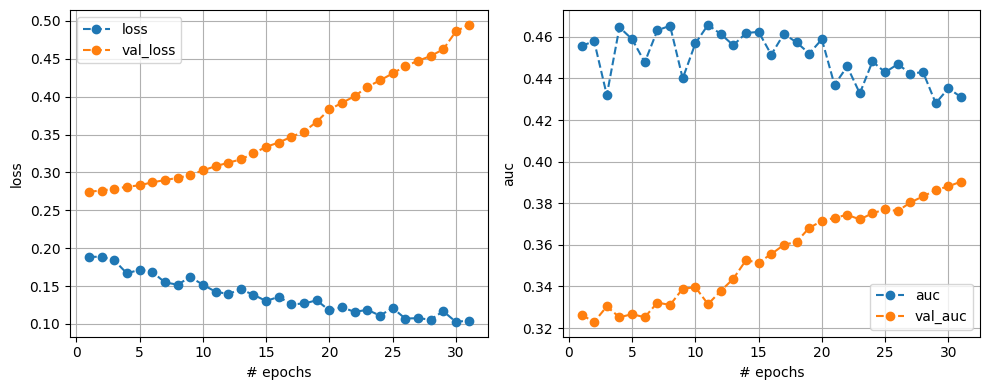

24/24 [==============================] - 6s 207ms/step - loss: 0.1044 - auc: 0.4310 - val_loss: 0.4949 - val_auc: 0.3904
Training time: 208.7879900932312 seconds


[I 2023-12-14 18:19:25,648] Trial 9 finished with value: 0.3903703987598419 and parameters: {'learning_rate': 4.838058146167004e-06}. Best is trial 4 with value: 0.5348148345947266.


Best trial: {'learning_rate': 6.339736695738739e-05}


In [18]:
# create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print('Best trial:', study.best_trial.params)

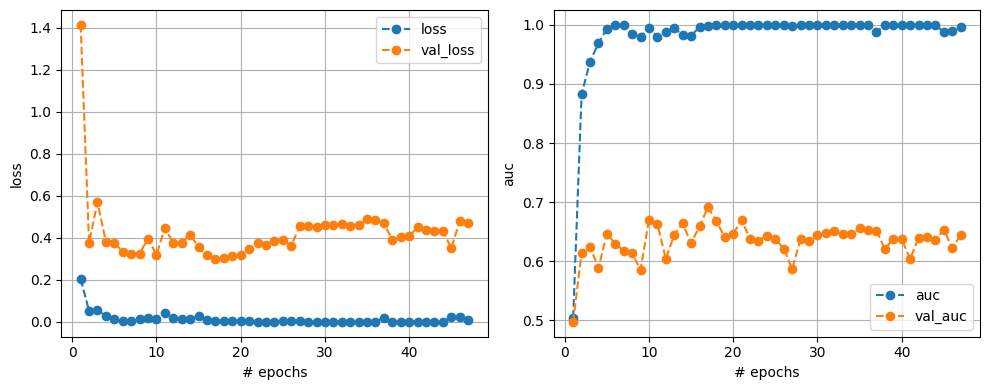

24/24 [==============================] - 6s 217ms/step - loss: 0.0071 - auc: 0.9964 - val_loss: 0.4717 - val_auc: 0.6437


In [19]:
# Extract the best hyperparameters
best_trial = study.best_trial.params

base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = build_model(base_model=base_model_VGG16, 
                    transfer_learning='Y', 
                    trial=optuna.trial.FixedTrial(best_trial))

# Unfreeze four top layers
for layer in model.layers[-4:]:  
    layer.trainable = True

# Callbacks
pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

# Retrain the model
history = model.fit(pla_prep_train_data,
                    epochs=150,
                    validation_data=pla_prep_val_data,
                    callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                    class_weight=pla_class_weights_dict
                     )

Best threshold: 0.00 with F1-score: 0.13


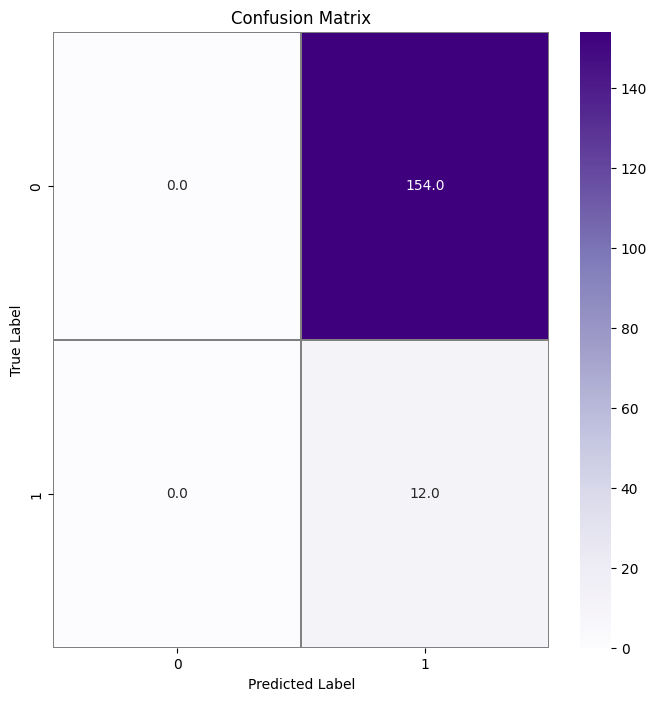

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_42/1616972866.py:58: RuntimeWarning: invalid valu

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.07      1.00      0.13        12

    accuracy                           0.07       166
   macro avg       0.04      0.50      0.07       166
weighted avg       0.01      0.07      0.01       166

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL-tuned  0.32                     0.13      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


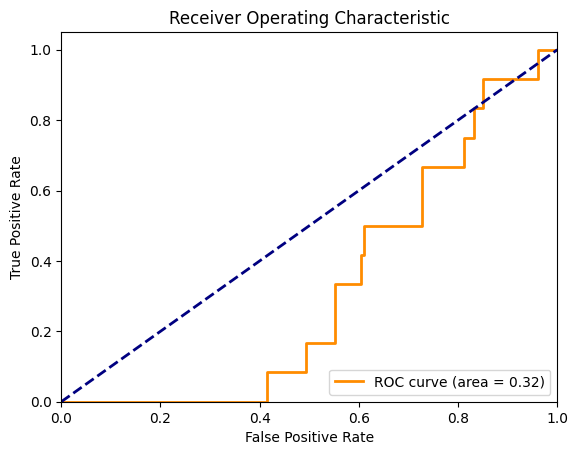

In [20]:
get_model_metrics(test_data=pla_prep_test_data, model=model, model_name='VGG16-no-TL-tuned')